In [2]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.nn.functional import conv1d, pad
from torch.fft import fft
from torchaudio.transforms import FFTConvolve
import time
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import fftconvolve

In [36]:
def objective_torch(a, b):
    """
    Computes the loss for the optimization problem.

    This function calculates the loss as the squared norm of the difference
    between the sum of convolutions of two polynomials (a and b) with their
    flipped versions and a delta function centered at the middle index.

    Parameters
    ----------
    a : torch.Tensor
        Coefficient of the first polynomial.
    b : torch.Tensor
        Coefficient of the second polynomial.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    a.requires_grad = True
    b.requires_grad = True

    # Compute loss using squared distance function
    delta = torch.zeros(2*len(a)-1, device=device)
    delta[len(a)-1] = 1
    loss = torch.norm(FFTConvolve("full").forward(a, torch.flip(a, dims=[0])) + FFTConvolve("full").forward(b, torch.flip(b, dims=[0])) - delta)**2
    return loss


# Set up optimizer
N = 32  # degree of polynomial
initial_a = torch.randn(N, device=device, requires_grad=True)
initial_b = torch.randn(N, device=device, requires_grad=True)
initial_a = (initial_a / torch.norm(initial_a)).clone().detach().requires_grad_(True)
initial_b = (initial_b / torch.norm(initial_b)).clone().detach().requires_grad_(True)
optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=1000, line_search_fn="strong_wolfe", tolerance_grad=1e-10)


def closure():
    """
    Closure function for the optimizer.

    This function zeroes the gradients, computes the loss using the objective_torch
    function, and performs backpropagation to compute the gradients.

    Returns
    -------
    torch.Tensor
        The computed loss value.
    """
    optimizer.zero_grad()
    loss = objective_torch(initial_a, initial_b)
    loss.backward()
    return loss


# Perform the optimization step using the closure function and record the time
t0 = time.time()
optimizer.step(closure)
t1 = time.time()
total = t1 - t0

print(f'N: {N}')
print(f'Time: {total}')
print(f'Final: {closure().item()}')
print(f"# Iterations: {optimizer.state[optimizer._params[0]]['n_iter']}")
print("-----------------------------------------------------")

N: 32
Time: 0.2842400074005127
Final: 5.154334736801047e-10
# Iterations: 52
-----------------------------------------------------


In [37]:
new_a = optimizer._params[0].detach().cpu().numpy()
new_b = optimizer._params[1].detach().cpu().numpy()

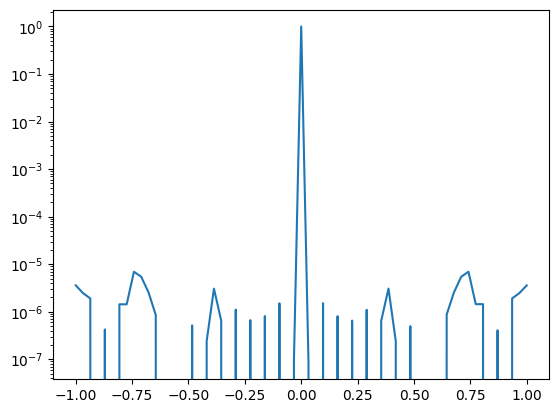

In [38]:
coefs_constraint_new = fftconvolve(new_a, np.flip(np.conj(new_a)), mode='full') + fftconvolve(new_b, np.flip(np.conj(new_b)), mode='full')
xvals = np.linspace(-1, 1, len(coefs_constraint_new))
plt.plot(xvals, np.real(coefs_constraint_new))
plt.yscale("log")
plt.show()

In [39]:
constraint_ideal = np.zeros(len(coefs_constraint_new))
constraint_ideal[int(len(constraint_ideal)/2)] = 1
max(abs(coefs_constraint_new - constraint_ideal))

8.73766839504242e-06

In [11]:
len(new_a)

32

In [ ]:
len(coefs_constraint_new)

63

In [15]:
coefs_constraint_no1 = np.append(coefs_constraint_new[:len(new_a)-1], coefs_constraint_new[len(new_a):])
coefs_constraint_mid = coefs_constraint_new[len(new_a)-1]
max(max(coefs_constraint_no1), abs(1-coefs_constraint_mid))

2.2121705e-05

In [46]:
def get_error_in_opt(N, strong_wolfe=True):
    def objective_torch(a, b):
        """
        Computes the loss for the optimization problem.

        This function calculates the loss as the squared norm of the difference
        between the sum of convolutions of two polynomials (a and b) with their
        flipped versions and a delta function centered at the middle index.

        Parameters
        ----------
        a : torch.Tensor
            Coefficient of the first polynomial.
        b : torch.Tensor
            Coefficient of the second polynomial.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        a.requires_grad = True
        b.requires_grad = True

        # Compute loss using squared distance function
        delta = torch.zeros(2*len(a)-1, device=device)
        delta[len(a)-1] = 1
        loss = torch.norm(FFTConvolve("full").forward(a, torch.flip(a, dims=[0])) + FFTConvolve("full").forward(b, torch.flip(b, dims=[0])) - delta)**2
        return loss

    # Set up optimizer
    initial_a = torch.randn(N, device=device, requires_grad=True)
    initial_b = torch.randn(N, device=device, requires_grad=True)
    initial_a = (initial_a / torch.norm(initial_a)).clone().detach().requires_grad_(True)
    initial_b = (initial_b / torch.norm(initial_b)).clone().detach().requires_grad_(True)
    if strong_wolfe:
        optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=1000, line_search_fn="strong_wolfe", tolerance_grad=1e-10)
    else:
        optimizer = torch.optim.LBFGS([initial_a, initial_b], max_iter=1000, tolerance_grad=1e-10)

    def closure():
        """
        Closure function for the optimizer.

        This function zeroes the gradients, computes the loss using the objective_torch
        function, and performs backpropagation to compute the gradients.

        Returns
        -------
        torch.Tensor
            The computed loss value.
        """
        optimizer.zero_grad()
        loss = objective_torch(initial_a, initial_b)
        loss.backward()
        return loss

    # do optimization and get error
    optimizer.step(closure)
    new_a = optimizer._params[0].detach().cpu().numpy()
    new_b = optimizer._params[1].detach().cpu().numpy()
    coefs_constraint_new = fftconvolve(new_a, np.flip(np.conj(new_a)), mode='full') + fftconvolve(new_b, np.flip(np.conj(new_b)), mode='full')
    constraint_ideal = np.zeros(len(coefs_constraint_new))
    constraint_ideal[int(len(constraint_ideal)/2)] = 1
    return max(abs(coefs_constraint_new - constraint_ideal))

In [48]:
get_error_in_opt(32, strong_wolfe=False)

0.0002536773681640625